In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import logging
from typing import Dict, List, Union, Tuple, Optional
import seaborn as sns
import matplotlib.pyplot as plt
# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [4]:
class SentimentAnalyzer:
    def __init__(self, glove_model: Dict[str, np.ndarray], 
                 balance_strategy: str = 'class_weight',
                 embedding_dim: int = 100):
        self.glove_model = glove_model
        self.embedding_dim = embedding_dim
        self.balance_strategy = balance_strategy
        self.classifier = None

    def validate_and_clean_ratings(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Validate and clean ratings column
        
        Args:
            df: Input DataFrame
            
        Returns:
            DataFrame with cleaned ratings
        """
        df = df.copy()
        
        # Check if 'rating' column exists
        if 'rating' not in df.columns:
            raise ValueError("Rating column not found in DataFrame")
            
        # Convert ratings to numeric, coerce errors to NaN
        df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
        
        # Print initial statistics
        print("\nRating Statistics Before Cleaning:")
        print(f"Total rows: {len(df)}")
        print(f"Missing ratings: {df['rating'].isna().sum()}")
        print("\nRating Distribution:")
        print(df['rating'].value_counts().sort_index())
        
        # Filter invalid ratings
        invalid_mask = ~df['rating'].between(1, 5)
        invalid_count = invalid_mask.sum()
        if invalid_count > 0:
            print(f"\nFound {invalid_count} invalid ratings (not between 1-5)")
            
        # Create clean ratings mask
        valid_mask = (
            df['rating'].between(1, 5) &  # Rating between 1-5
            df['rating'].notna() &        # Rating is not NaN
            df['review_text'].notna()     # Review text is not NaN
        )
        
        # Apply cleaning
        df_cleaned = df[valid_mask].copy()
        
        # Print cleaning results
        print("\nCleaning Results:")
        print(f"Original rows: {len(df)}")
        print(f"Rows after cleaning: {len(df_cleaned)}")
        print(f"Removed rows: {len(df) - len(df_cleaned)}")
        
        return df_cleaned

    def convert_ratings_to_sentiment(self, rating: float) -> int:
        """
        Convert 1-5 rating to sentiment class
        
        Args:
            rating: Rating value (1-5)
            
        Returns:
            0 for negative (1-2)
            1 for neutral (3)
            2 for positive (4-5)
        """
        if pd.isna(rating):
            raise ValueError("Rating cannot be NaN")
            
        if not 1 <= rating <= 5:
            raise ValueError(f"Rating {rating} is not between 1 and 5")
            
        if rating <= 2:
            return 0  # Negative
        elif rating == 3:
            return 1  # Neutral
        else:
            return 2  # Positive

    def prepare_data(self, df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray]:
        """
        Prepare features and labels from the dataset
        """
        # Clean and validate ratings
        df_cleaned = self.validate_and_clean_ratings(df)
        
        # Convert ratings to sentiment classes
        try:
            df_cleaned['sentiment'] = df_cleaned['rating'].apply(self.convert_ratings_to_sentiment)
        except Exception as e:
            print(f"Error converting ratings to sentiment: {str(e)}")
            raise
            
        # Print sentiment distribution
        print("\nSentiment Distribution:")
        sentiment_counts = df_cleaned['sentiment'].value_counts().sort_index()
        for sentiment, count in sentiment_counts.items():
            sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
            percentage = (count / len(df_cleaned)) * 100
            print(f"{sentiment_map[sentiment]}: {count} ({percentage:.2f}%)")
        
        # Process reviews and create embedding vectors
        X = []
        y = []
        
        for idx, row in df_cleaned.iterrows():
            try:
                # Skip if review text is missing
                if pd.isna(row['review_text']):
                    continue
                    
                tokens = self.preprocess_text(row['review_text'])
                if tokens:  # Only process if we have valid tokens
                    embedding = self.get_embedding_vector(tokens)
                    X.append(embedding)
                    y.append(row['sentiment'])
            except Exception as e:
                print(f"Error processing row {idx}: {str(e)}")
                continue
        
        return np.array(X), np.array(y)

    def preprocess_text(self, text: str) -> List[str]:
        """
        Preprocess the text
        """
        if pd.isna(text):
            return []
            
        # Convert to string if not already
        text = str(text)
        
        # Convert to lowercase
        text = text.lower()
        
        # Remove special characters and digits
        text = re.sub(r'[^a-zA-Z\s]', '', text)
        
        # Tokenize
        tokens = word_tokenize(text)
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]
        
        return tokens

    def get_embedding_vector(self, tokens: List[str]) -> np.ndarray:
        """
        Convert tokens to their average GloVe embedding vector
        """
        vectors = []
        missing_words = []
        
        for token in tokens:
            try:
                vectors.append(self.glove_model[token])
            except KeyError:
                missing_words.append(token)
        
        if vectors:
            return np.mean(vectors, axis=0)
        else:
            return np.zeros(self.embedding_dim)


    def train(self, X_train: np.ndarray, y_train: np.ndarray) -> None:
        """
        Train the model with the selected class balancing strategy
        """
        print("\nTraining model...")
        print(f"Training data shape: {X_train.shape}")
        
        if self.balance_strategy == 'class_weight':
            # Compute class weights
            classes = np.unique(y_train)
            class_weights = dict(zip(classes, 
                                   len(y_train) / (len(classes) * np.bincount(y_train))))
            
            self.classifier = LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                class_weight=class_weights,
                max_iter=1000,
                random_state=42
            )
            
        elif self.balance_strategy == 'smote':
            # Apply SMOTE
            smote = SMOTE(random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)
            
            self.classifier = LogisticRegression(
                multi_class='multinomial',
                solver='lbfgs',
                max_iter=1000,
                random_state=42
            )
            
        print("Fitting classifier...")
        self.classifier.fit(X_train, y_train)
        print("Training completed!")

    def evaluate(self, X_test: np.ndarray, y_test: np.ndarray) -> Dict:
        """
        Evaluate the model and return metrics
        
        Returns:
            Dictionary containing evaluation metrics
        """
        if self.classifier is None:
            raise ValueError("Model not trained. Call train() first.")
            
        print("\nEvaluating model...")
        
        # Get predictions
        y_pred = self.classifier.predict(X_test)
        
        # Calculate probabilities for each class
        y_prob = self.classifier.predict_proba(X_test)
        
        # Print classification report
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred,
                                 target_names=['Negative', 'Neutral', 'Positive']))
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        
        # Plot confusion matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['Negative', 'Neutral', 'Positive'],
                   yticklabels=['Negative', 'Neutral', 'Positive'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # Return metrics dictionary
        return {
            'confusion_matrix': cm,
            'predictions': y_pred,
            'probabilities': y_prob
        }

    def predict(self, text: str) -> Tuple[str, Dict[str, float]]:
        """
        Predict sentiment for a single text input
        
        Returns:
            Tuple of (predicted_sentiment, probability_dict)
        """
        if self.classifier is None:
            raise ValueError("Model not trained. Call train() first.")
            
        # Preprocess the text
        tokens = self.preprocess_text(text)
        if not tokens:
            raise ValueError("No valid tokens extracted from input text")
            
        # Get embedding
        embedding = self.get_embedding_vector(tokens)
        
        # Get prediction and probabilities
        sentiment = self.classifier.predict([embedding])[0]
        probabilities = self.classifier.predict_proba([embedding])[0]
        
        # Convert to human-readable format
        sentiment_map = {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
        prob_dict = {sentiment_map[i]: prob for i, prob in enumerate(probabilities)}
        
        return sentiment_map[sentiment], prob_dict


Rating Statistics Before Cleaning:
Total rows: 1597
Missing ratings: 420

Rating Distribution:
rating
1.0     42
2.0     34
3.0    124
4.0    236
5.0    741
Name: count, dtype: int64

Found 420 invalid ratings (not between 1-5)

Cleaning Results:
Original rows: 1597
Rows after cleaning: 1177
Removed rows: 420

Sentiment Distribution:
Negative: 76 (6.46%)
Neutral: 124 (10.54%)
Positive: 977 (83.01%)

Training model...
Training data shape: (940, 100)
Fitting classifier...
Training completed!

Evaluating model...

Classification Report:
              precision    recall  f1-score   support

    Negative       0.30      0.73      0.42        15
     Neutral       0.33      0.56      0.41        25
    Positive       0.95      0.76      0.84       196

    accuracy                           0.73       236
   macro avg       0.52      0.68      0.56       236
weighted avg       0.84      0.73      0.77       236



c:\Users\manwi\anaconda3\envs\sentiment_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


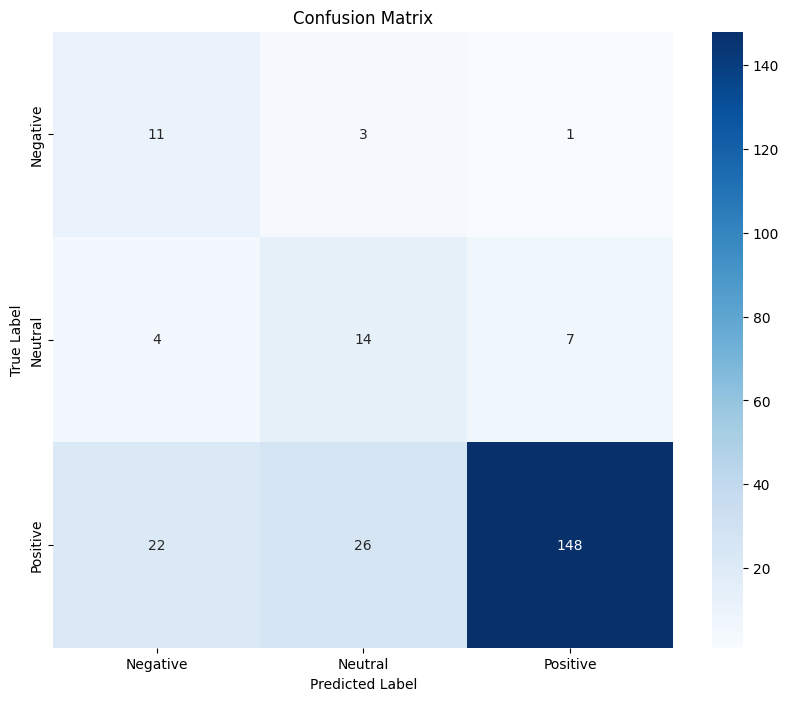


Predicted sentiment: Positive
Class probabilities:
Negative: 0.00
Neutral: 0.01
Positive: 0.99


In [5]:
# Example usage:

# Load your data
df = pd.read_csv('../data/7817_1.csv')
df = df.rename(columns={'reviews.text': 'review_text', 'reviews.rating': 'rating'})

# Load your data and GloVe embeddings
glove_model = {}
with open('../assets/glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_model[word] = vector


# Initialize analyzer
analyzer = SentimentAnalyzer(glove_model)

# Prepare data
X, y = analyzer.prepare_data(df)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

# Train model
analyzer.train(X_train, y_train)

# Evaluate model
metrics = analyzer.evaluate(X_test, y_test)

# Make predictions
text = "This product is amazing! I love it!"
sentiment, probabilities = analyzer.predict(text)
print(f"\nPredicted sentiment: {sentiment}")
print("Class probabilities:")
for sentiment, prob in probabilities.items():
    print(f"{sentiment}: {prob:.2f}")

In [12]:
sample_review = "This product FREAKING SUCKS"
sentiment, probabilities = analyzer.predict(sample_review)
print(sentiment)

Negative
